###Q1 A all 128 Experiments

In [ ]:
"""
DLOps Assignment-1: ULTRA-OPTIMIZED Training Script
Fixed for multiprocessing compatibility
Optimizations for 2x T4 GPUs with sequential GPU switching
"""

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, ConcatDataset
import pandas as pd
import numpy as np
import os
import time
import logging
from tqdm import tqdm
import itertools
from sklearn.metrics import precision_recall_fscore_support


# CONFIGURATION

RESULTS_DIR = "results_optimized"
os.makedirs(RESULTS_DIR, exist_ok=True)
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Setup Logging
logging.basicConfig(
    filename=os.path.join(RESULTS_DIR, "training_log.txt"),
    level=logging.INFO,
    format='%(asctime)s - %(message)s'
)

# Check GPU availability
if not torch.cuda.is_available():
    raise RuntimeError("⚠️ No GPU detected! This script requires GPU.")

gpu_count = torch.cuda.device_count()
print(f"🚀 Detected {gpu_count} GPUs")
for i in range(gpu_count):
    print(f"   GPU {i}: {torch.cuda.get_device_name(i)}")

# ==========================================
# OPTIMIZED DATA LOADING
# ==========================================
class OptimizedDataManager:
    """Manages all dataloaders efficiently"""

    def __init__(self):
        self.loaders = {}
        self._create_all_loaders()

    def _create_all_loaders(self):
        """Pre-create all dataloaders"""
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

        datasets_info = {
            'MNIST': torchvision.datasets.MNIST,
            'FashionMNIST': torchvision.datasets.FashionMNIST
        }

        for name, dataset_class in datasets_info.items():
            # Load full dataset
            train_data = dataset_class(root='./data', train=True, download=True, transform=transform)
            test_data = dataset_class(root='./data', train=False, download=True, transform=transform)

            # Combine for 70-10-20 split
            full_dataset = ConcatDataset([train_data, test_data])

            total_len = len(full_dataset)
            train_len = int(0.7 * total_len)
            val_len = int(0.1 * total_len)
            test_len = total_len - train_len - val_len

            generator = torch.Generator().manual_seed(RANDOM_SEED)
            train_set, val_set, test_set = random_split(
                full_dataset, [train_len, val_len, test_len], generator=generator
            )

            # Create loaders for both batch sizes
            for bs in [16, 32]:
                self.loaders[f"{name}_{bs}_train"] = DataLoader(
                    train_set, batch_size=bs, shuffle=True,
                    num_workers=4, pin_memory=True, persistent_workers=True
                )
                self.loaders[f"{name}_{bs}_val"] = DataLoader(
                    val_set, batch_size=bs, shuffle=False,
                    num_workers=2, pin_memory=True, persistent_workers=True
                )
                self.loaders[f"{name}_{bs}_test"] = DataLoader(
                    test_set, batch_size=bs, shuffle=False,
                    num_workers=2, pin_memory=True, persistent_workers=True
                )

    def get_loaders(self, dataset, batch_size):
        """Get train, val, test loaders for a configuration"""
        key = f"{dataset}_{batch_size}"
        return (
            self.loaders[f"{key}_train"],
            self.loaders[f"{key}_val"],
            self.loaders[f"{key}_test"]
        )

# Initialize data manager
print("\n⏳ Pre-loading datasets (one-time operation)...")
data_manager = OptimizedDataManager()
print("✅ All DataLoaders ready")

# ==========================================
# TRAINING FUNCTION
# ==========================================
def train_single_experiment(run_id, config, gpu_id):
    """Execute one experiment on specified GPU"""

    device = torch.device(f'cuda:{gpu_id}')
    torch.cuda.set_device(device)

    try:
        # Get loaders
        train_loader, val_loader, test_loader = data_manager.get_loaders(
            config['dataset'], config['batch_size']
        )

        # Model initialization
        if config['model'] == 'ResNet18':
            model = torchvision.models.resnet18(weights=None)
        else:
            model = torchvision.models.resnet50(weights=None)

        # Modify for grayscale input
        model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        model.fc = nn.Linear(model.fc.in_features, 10)
        model = model.to(device)

        # Optimizer
        if config['optimizer'] == 'SGD':
            optimizer = optim.SGD(model.parameters(), lr=config['lr'], momentum=0.9)
        else:
            optimizer = optim.Adam(model.parameters(), lr=config['lr'])

        criterion = nn.CrossEntropyLoss()
        scaler = torch.amp.GradScaler('cuda')

        # Training loop
        best_val_acc = 0.0
        start_time = time.time()

        for epoch in range(config['epochs']):
            # Training phase
            model.train()
            train_loss = 0.0

            for inputs, labels in train_loader:
                inputs = inputs.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)

                optimizer.zero_grad(set_to_none=True)

                with torch.amp.autocast('cuda'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

                train_loss += loss.item()

            # Validation phase
            model.eval()
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs = inputs.to(device, non_blocking=True)
                    labels = labels.to(device, non_blocking=True)

                    with torch.amp.autocast('cuda'):
                        outputs = model(inputs)

                    _, predicted = outputs.max(1)
                    val_total += labels.size(0)
                    val_correct += predicted.eq(labels).sum().item()

            val_acc = 100.0 * val_correct / val_total
            best_val_acc = max(best_val_acc, val_acc)

        training_time = time.time() - start_time

        # Final test evaluation
        model.eval()
        all_preds, all_labels = [], []

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)

                with torch.amp.autocast('cuda'):
                    outputs = model(inputs)

                _, predicted = outputs.max(1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Calculate metrics
        precision, recall, f1, _ = precision_recall_fscore_support(
            all_labels, all_preds, average='weighted', zero_division=0
        )

        test_acc = 100.0 * np.mean(np.array(all_preds) == np.array(all_labels))

        # Clean up GPU memory
        del model, optimizer
        torch.cuda.empty_cache()

        result = {
            'run_id': run_id,
            'dataset': config['dataset'],
            'model': config['model'],
            'batch_size': config['batch_size'],
            'optimizer': config['optimizer'],
            'lr': config['lr'],
            'pin_memory': config['pin_memory'],
            'epochs': config['epochs'],
            'test_accuracy': round(test_acc, 6),
            'test_f1': round(f1, 6),
            'test_precision': round(precision, 6),
            'test_recall': round(recall, 6),
            'training_time_sec': round(training_time, 6),
            'gpu_id': gpu_id
        }

        return result

    except Exception as e:
        logging.error(f"Run {run_id} failed: {e}")
        import traceback
        traceback.print_exc()
        return {
            'run_id': run_id,
            'error': str(e),
            'dataset': config.get('dataset', 'unknown'),
            'model': config.get('model', 'unknown')
        }


# SMART GPU ALTERNATION

def run_experiments_smart():
    """Run experiments with intelligent GPU switching"""

    # Generate all configurations
    keys = ['dataset', 'model', 'batch_size', 'optimizer', 'lr', 'pin_memory', 'epochs']
    values = [
        ['MNIST', 'FashionMNIST'],
        ['ResNet18', 'ResNet50'],
        [16, 32],
        ['SGD', 'Adam'],
        [0.001, 0.0001],
        [False, True],
        [2, 5]
    ]

    all_configs = [dict(zip(keys, v)) for v in itertools.product(*values)]
    total_experiments = len(all_configs)

    print(f"\n🚀 Total Experiments: {total_experiments}")
    print(f"📊 Running sequentially with GPU alternation\n")

    results_list = []

    # Progress bar
    pbar = tqdm(total=total_experiments, desc="Overall Progress", unit="exp")

    for i, config in enumerate(all_configs):
        # Alternate between GPUs (round-robin)
        gpu_id = i % gpu_count

        # Update progress bar description
        pbar.set_description(
            f"Exp {i+1}/{total_experiments} | GPU{gpu_id} | {config['dataset']} {config['model']}"
        )

        # Run experiment
        result = train_single_experiment(i, config, gpu_id)
        results_list.append(result)

        # Save checkpoint every 16 experiments
        if (i + 1) % 16 == 0:
            df_partial = pd.DataFrame(results_list)
            df_partial.to_csv(
                os.path.join(RESULTS_DIR, f"checkpoint_{i+1}.csv"),
                index=False
            )
            logging.info(f"Checkpoint saved at experiment {i+1}")

        pbar.update(1)

    pbar.close()
    return results_list


# MAIN EXECUTION

if __name__ == "__main__":
    start_time_global = time.time()

    print("=" * 70)
    print("OPTIMIZED TRAINING PIPELINE - T4x2 GPU")
    print("=" * 70)

    # Run all experiments
    results = run_experiments_smart()

    total_time = time.time() - start_time_global

    # Save final results
    df_final = pd.DataFrame(results)
    df_final.to_csv(os.path.join(RESULTS_DIR, "final_results.csv"), index=False)

    # Print summary
    print("\n" + "=" * 70)
    print("✅ ALL EXPERIMENTS COMPLETED")
    print("=" * 70)
    print(f"Total Time: {total_time/60:.2f} minutes")
    print(f"Average Time per Experiment: {total_time/len(results):.2f} seconds")
    print(f"Results saved to: {RESULTS_DIR}/final_results.csv")

    # Display statistics
    if 'test_accuracy' in df_final.columns:
        print("\n📊 Summary Statistics:")
        print(f"   Mean Accuracy: {df_final['test_accuracy'].mean():.2f}%")
        print(f"   Max Accuracy: {df_final['test_accuracy'].max():.2f}%")
        print(f"   Mean F1 Score: {df_final['test_f1'].mean():.4f}")

        print("\n🏆 Top 5 Configurations by Accuracy:")
        top_5 = df_final.nlargest(5, 'test_accuracy')[
            ['dataset', 'model', 'batch_size', 'optimizer', 'lr', 'epochs', 'test_accuracy']
        ]
        print(top_5.to_string(index=False))

    # GPU utilization summary
    if 'gpu_id' in df_final.columns:
        print("\n🖥️ GPU Utilization:")
        gpu_counts = df_final['gpu_id'].value_counts().sort_index()
        for gpu_id, count in gpu_counts.items():
            print(f"   GPU {gpu_id}: {count} experiments")

    print("\n" + "=" * 70)

🚀 Detected 2 GPUs
   GPU 0: Tesla T4
   GPU 1: Tesla T4

⏳ Pre-loading datasets (one-time operation)...


100%|██████████| 9.91M/9.91M [00:00<00:00, 43.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.17MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.82MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.2MB/s]
100%|██████████| 26.4M/26.4M [00:14<00:00, 1.85MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 275kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.06MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 13.4MB/s]


✅ All DataLoaders ready
OPTIMIZED TRAINING PIPELINE - T4x2 GPU

🚀 Total Experiments: 128
📊 Running sequentially with GPU alternation



Exp 128/128 | GPU1 | FashionMNIST ResNet50: 100%|██████████| 128/128 [6:58:21<00:00, 196.10s/exp]


✅ ALL EXPERIMENTS COMPLETED
Total Time: 418.36 minutes
Average Time per Experiment: 196.10 seconds
Results saved to: results_optimized/final_results.csv

📊 Summary Statistics:
   Mean Accuracy: 92.03%
   Max Accuracy: 99.06%
   Mean F1 Score: 0.9195

🏆 Top 5 Configurations by Accuracy:
dataset    model  batch_size optimizer     lr  epochs  test_accuracy
  MNIST ResNet18          16       SGD 0.0010       5      99.064286
  MNIST ResNet18          32       SGD 0.0010       5      98.978571
  MNIST ResNet18          32      Adam 0.0010       5      98.964286
  MNIST ResNet18          16       SGD 0.0010       5      98.907143
  MNIST ResNet18          16      Adam 0.0001       5      98.857143

🖥️ GPU Utilization:
   GPU 0: 64 experiments
   GPU 1: 64 experiments



###Q1 B Experiments

DLOps Assignment-1 Q1(b): SVM Classifier Training with PyTorch
Device: cuda
Output is being saved to 'results/training_output.txt'
Models will be saved to 'models/*.pth' and 'models/*.pkl'

[1] Loading MNIST and FashionMNIST Datasets using PyTorch...


100%|██████████| 9.91M/9.91M [00:00<00:00, 38.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.18MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.2MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.60MB/s]
100%|██████████| 26.4M/26.4M [00:01<00:00, 15.8MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 273kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.11MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 14.4MB/s]


MNIST - Training samples: 60000, Test samples: 10000
FashionMNIST - Training samples: 60000, Test samples: 10000

[2] Preparing Data for SVM Training...
Using 10000 training samples for each dataset...

MNIST - Train shape: (10000, 784), Test shape: (10000, 784)
FashionMNIST - Train shape: (10000, 784), Test shape: (10000, 784)

[3] Standardizing features...
Data preprocessing completed!

[4] Defining SVM Hyperparameter Configurations...
Total configurations to test: 15
Total experiments: 30 (MNIST + FashionMNIST)

[5] Training SVM Classifiers...

>>> TRAINING ON MNIST DATASET <<<

[1/15] Poly-1: kernel=poly, C=0.1, degree=2
    ✓ Accuracy: 93.25% | Time: 11341.31 ms | Saved: models/svm_MNIST_Poly-1.pth

[2/15] Poly-2: kernel=poly, C=1.0, degree=2
    ✓ Accuracy: 95.01% | Time: 6017.65 ms | Saved: models/svm_MNIST_Poly-2.pth

[3/15] Poly-3: kernel=poly, C=10.0, degree=2
    ✓ Accuracy: 95.09% | Time: 5345.49 ms | Saved: models/svm_MNIST_Poly-3.pth

[4/15] Poly-4: kernel=poly, C=0.1, de

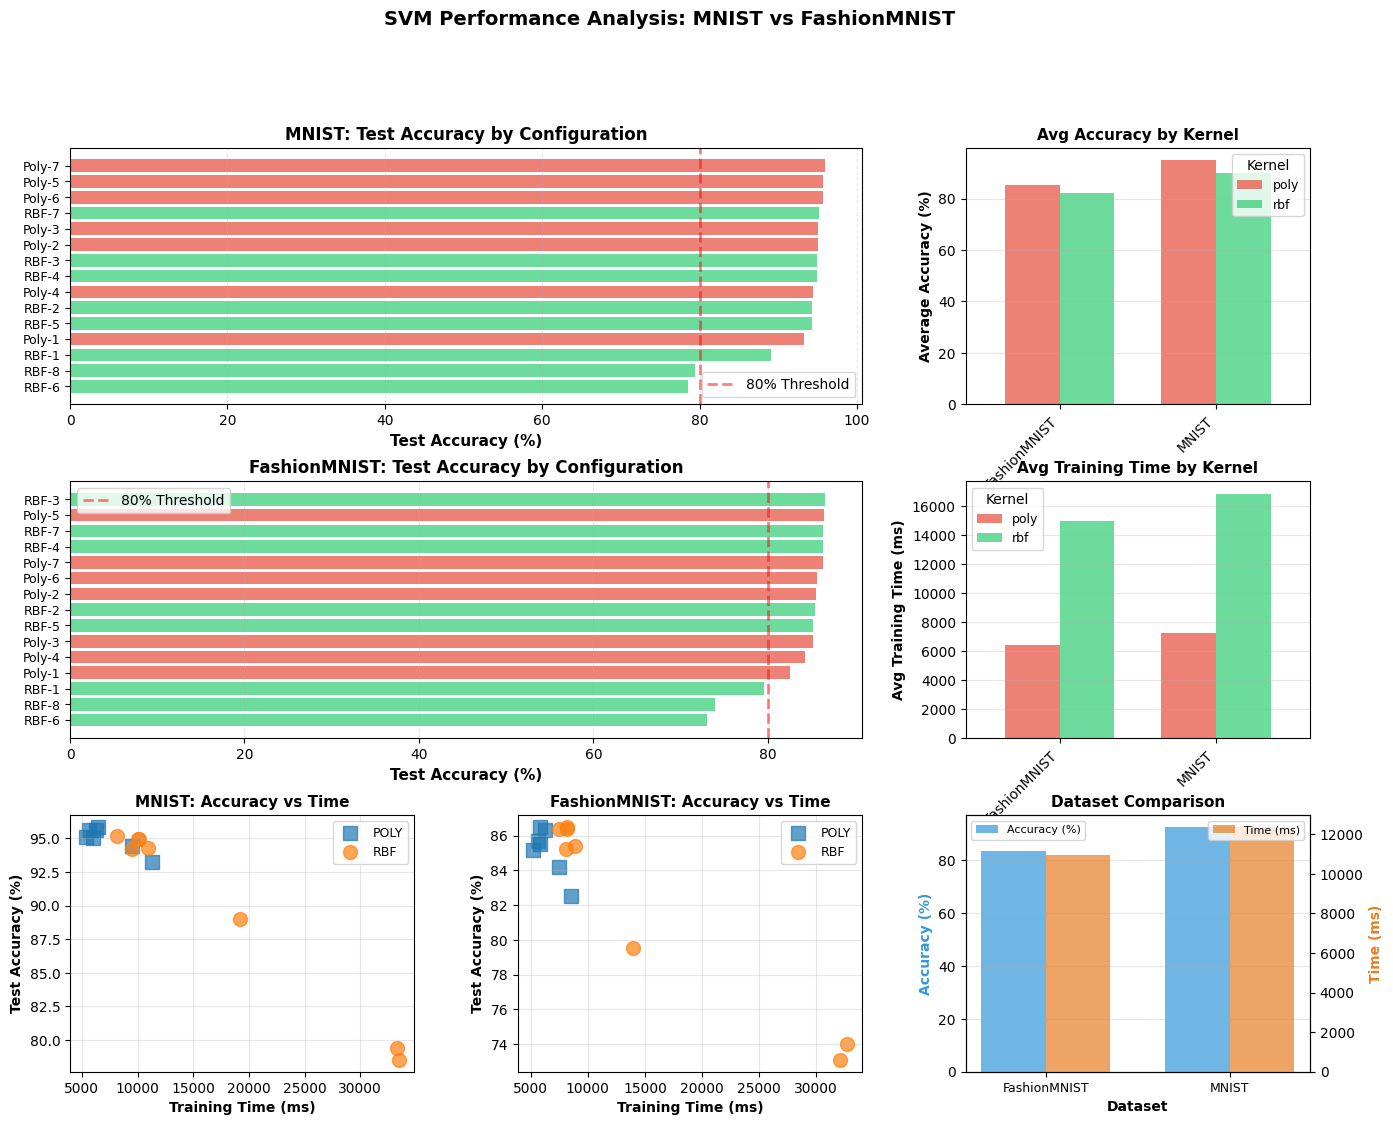


✓ Results saved to 'results/svm_pytorch_results.csv'

FORMATTED TABLE FOR REPORT

     Dataset Config Kernel     C Degree  Gamma  Test Accuracy (%)  Training Time (ms)
       MNIST Poly-1   poly   0.1      2  scale              93.25            11341.31
       MNIST Poly-2   poly   1.0      2  scale              95.01             6017.65
       MNIST Poly-3   poly  10.0      2  scale              95.09             5345.49
       MNIST Poly-4   poly   0.1      3  scale              94.41             9512.27
       MNIST Poly-5   poly   1.0      3  scale              95.64             6231.70
       MNIST Poly-6   poly  10.0      3  scale              95.62             5662.27
       MNIST Poly-7   poly   1.0      4  scale              95.86             6426.30
       MNIST  RBF-1    rbf   0.1      -  scale              89.03            19195.50
       MNIST  RBF-2    rbf   1.0      -  scale              94.29            10965.16
       MNIST  RBF-3    rbf  10.0      -  scale           

In [ ]:
"""
DLOps Assignment-1 Q1(b)
SVM Classifier on MNIST and FashionMNIST Datasets
Using PyTorch for data loading and preprocessing
Author: [Your Name]
Roll Number: [Your Roll Number]
"""

import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import time
import pandas as pd
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib  # Added for saving models
import sys
import os

warnings.filterwarnings('ignore')

# ===========================
# 0. Setup Logging and Directories
# ===========================
# Create directories to keep files organized
os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)

# Logger class to redirect output to both terminal and file
class Logger(object):
    def __init__(self):
        self.terminal = sys.stdout
        self.log = open("results/training_output.txt", "w")

    def write(self, message):
        self.terminal.write(message)
        self.log.write(message)

    def flush(self):
        self.terminal.flush()
        self.log.flush()

# Start logging
sys.stdout = Logger()

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("="*80)
print("DLOps Assignment-1 Q1(b): SVM Classifier Training with PyTorch")
print("="*80)
print(f"Device: {device}")
print("Output is being saved to 'results/training_output.txt'")
print("Models will be saved to 'models/*.pth' and 'models/*.pkl'")
print()

# ===========================
# 1. Load Datasets using PyTorch
# ===========================
print("[1] Loading MNIST and FashionMNIST Datasets using PyTorch...")

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Load MNIST Dataset
train_dataset_mnist = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset_mnist = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

# Load FashionMNIST Dataset
train_dataset_fashion = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset_fashion = torchvision.datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

print(f"MNIST - Training samples: {len(train_dataset_mnist)}, Test samples: {len(test_dataset_mnist)}")
print(f"FashionMNIST - Training samples: {len(train_dataset_fashion)}, Test samples: {len(test_dataset_fashion)}")

# ===========================
# 2. Prepare Data for SVM
# ===========================
print("\n[2] Preparing Data for SVM Training...")

def prepare_data(dataset, subset_size=None):
    """
    Convert PyTorch dataset to numpy arrays for SVM
    """
    loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset), shuffle=False)
    data, labels = next(iter(loader))

    # Flatten images
    data = data.view(data.size(0), -1).numpy()
    labels = labels.numpy()

    # Use subset if specified (SVM is computationally expensive)
    if subset_size and subset_size < len(labels):
        indices = np.random.choice(len(labels), subset_size, replace=False)
        data = data[indices]
        labels = labels[indices]

    return data, labels

# Prepare MNIST data
subset_train_size = 10000  # Use 10,000 samples for faster training
print(f"Using {subset_train_size} training samples for each dataset...")

X_train_mnist, y_train_mnist = prepare_data(train_dataset_mnist, subset_train_size)
X_test_mnist, y_test_mnist = prepare_data(test_dataset_mnist)

# Prepare FashionMNIST data
X_train_fashion, y_train_fashion = prepare_data(train_dataset_fashion, subset_train_size)
X_test_fashion, y_test_fashion = prepare_data(test_dataset_fashion)

print(f"\nMNIST - Train shape: {X_train_mnist.shape}, Test shape: {X_test_mnist.shape}")
print(f"FashionMNIST - Train shape: {X_train_fashion.shape}, Test shape: {X_test_fashion.shape}")

# Standardize features (important for SVM)
print("\n[3] Standardizing features...")
scaler_mnist = StandardScaler()
X_train_mnist = scaler_mnist.fit_transform(X_train_mnist)
X_test_mnist = scaler_mnist.transform(X_test_mnist)

scaler_fashion = StandardScaler()
X_train_fashion = scaler_fashion.fit_transform(X_train_fashion)
X_test_fashion = scaler_fashion.transform(X_test_fashion)

print("Data preprocessing completed!")

# ===========================
# 3. Define SVM Configurations
# ===========================
print("\n[4] Defining SVM Hyperparameter Configurations...")

svm_configs = [
    # Polynomial Kernel Configurations
    {'name': 'Poly-1', 'kernel': 'poly', 'degree': 2, 'C': 0.1, 'gamma': 'scale', 'coef0': 1},
    {'name': 'Poly-2', 'kernel': 'poly', 'degree': 2, 'C': 1.0, 'gamma': 'scale', 'coef0': 1},
    {'name': 'Poly-3', 'kernel': 'poly', 'degree': 2, 'C': 10.0, 'gamma': 'scale', 'coef0': 1},
    {'name': 'Poly-4', 'kernel': 'poly', 'degree': 3, 'C': 0.1, 'gamma': 'scale', 'coef0': 1},
    {'name': 'Poly-5', 'kernel': 'poly', 'degree': 3, 'C': 1.0, 'gamma': 'scale', 'coef0': 1},
    {'name': 'Poly-6', 'kernel': 'poly', 'degree': 3, 'C': 10.0, 'gamma': 'scale', 'coef0': 1},
    {'name': 'Poly-7', 'kernel': 'poly', 'degree': 4, 'C': 1.0, 'gamma': 'scale', 'coef0': 1},

    # RBF Kernel Configurations
    {'name': 'RBF-1', 'kernel': 'rbf', 'C': 0.1, 'gamma': 'scale'},
    {'name': 'RBF-2', 'kernel': 'rbf', 'C': 1.0, 'gamma': 'scale'},
    {'name': 'RBF-3', 'kernel': 'rbf', 'C': 10.0, 'gamma': 'scale'},
    {'name': 'RBF-4', 'kernel': 'rbf', 'C': 100.0, 'gamma': 'scale'},
    {'name': 'RBF-5', 'kernel': 'rbf', 'C': 1.0, 'gamma': 0.001},
    {'name': 'RBF-6', 'kernel': 'rbf', 'C': 1.0, 'gamma': 0.01},
    {'name': 'RBF-7', 'kernel': 'rbf', 'C': 10.0, 'gamma': 0.001},
    {'name': 'RBF-8', 'kernel': 'rbf', 'C': 10.0, 'gamma': 0.01},
]

print(f"Total configurations to test: {len(svm_configs)}")
print(f"Total experiments: {len(svm_configs) * 2} (MNIST + FashionMNIST)")

# ===========================
# 4. Train SVM Models
# ===========================
results = []

print("\n[5] Training SVM Classifiers...")
print("="*80)

# Function to train and evaluate SVM
def train_evaluate_svm(X_train, y_train, X_test, y_test, config, dataset_name):
    """
    Train SVM, save model to .pkl AND .pth, and return results
    """
    config_copy = config.copy()
    config_name = config_copy.pop('name')

    # Create SVM classifier
    svm = SVC(**config_copy, random_state=42, max_iter=1000)

    # Measure training time in milliseconds
    start_time = time.time()
    svm.fit(X_train, y_train)
    end_time = time.time()
    training_time_ms = (end_time - start_time) * 1000

    # --- SAVE MODEL SECTION (UPDATED) ---
    # 1. Save as .pkl (Standard Scikit-Learn format)
    pkl_filename = f"models/svm_{dataset_name}_{config_name}.pkl"
    joblib.dump(svm, pkl_filename)

    # 2. Save as .pth (PyTorch format - using torch.save to serialize the object)
    pth_filename = f"models/svm_{dataset_name}_{config_name}.pth"
    torch.save(svm, pth_filename)

    # Predict on test set
    y_pred = svm.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred) * 100

    return {
        'Config': config_name,
        'Dataset': dataset_name,
        'Kernel': config['kernel'],
        'C': config.get('C', '-'),
        'Degree': config.get('degree', '-'),
        'Gamma': config.get('gamma', '-'),
        'Test Accuracy (%)': round(accuracy, 2),
        'Training Time (ms)': round(training_time_ms, 2),
        'Support Vectors': svm.n_support_.sum(),
        'Model File': pth_filename # Returning the .pth filename for the report
    }

# Train on MNIST Dataset
print("\n>>> TRAINING ON MNIST DATASET <<<\n")
for idx, config in enumerate(svm_configs, 1):
    print(f"[{idx}/{len(svm_configs)}] {config['name']}: kernel={config['kernel']}, C={config.get('C', '-')}", end='')
    if config['kernel'] == 'poly':
        print(f", degree={config['degree']}", end='')
    if 'gamma' in config and config['gamma'] != 'scale':
        print(f", gamma={config['gamma']}", end='')
    print()

    result = train_evaluate_svm(X_train_mnist, y_train_mnist,
                                X_test_mnist, y_test_mnist,
                                config, 'MNIST')

    print(f"    ✓ Accuracy: {result['Test Accuracy (%)']}% | Time: {result['Training Time (ms)']:.2f} ms | Saved: {result['Model File']}")
    print()

    results.append(result)

# Train on FashionMNIST Dataset
print("\n>>> TRAINING ON FASHION-MNIST DATASET <<<\n")
for idx, config in enumerate(svm_configs, 1):
    print(f"[{idx}/{len(svm_configs)}] {config['name']}: kernel={config['kernel']}, C={config.get('C', '-')}", end='')
    if config['kernel'] == 'poly':
        print(f", degree={config['degree']}", end='')
    if 'gamma' in config and config['gamma'] != 'scale':
        print(f", gamma={config['gamma']}", end='')
    print()

    result = train_evaluate_svm(X_train_fashion, y_train_fashion,
                                X_test_fashion, y_test_fashion,
                                config, 'FashionMNIST')

    print(f"    ✓ Accuracy: {result['Test Accuracy (%)']}% | Time: {result['Training Time (ms)']:.2f} ms | Saved: {result['Model File']}")
    print()

    results.append(result)

# ===========================
# 5. Create Results DataFrame
# ===========================
df_results = pd.DataFrame(results)

# ===========================
# 6. Display Results Tables
# ===========================
print("\n" + "="*80)
print("RESULTS SUMMARY")
print("="*80)

# MNIST Results
print("\n" + "="*80)
print("MNIST DATASET RESULTS")
print("="*80 + "\n")
df_mnist = df_results[df_results['Dataset'] == 'MNIST'].copy()
df_mnist = df_mnist.sort_values('Test Accuracy (%)', ascending=False)
print(df_mnist[['Config', 'Kernel', 'C', 'Degree', 'Gamma', 'Test Accuracy (%)', 'Training Time (ms)']].to_string(index=False))

# FashionMNIST Results
print("\n" + "="*80)
print("FASHION-MNIST DATASET RESULTS")
print("="*80 + "\n")
df_fashion = df_results[df_results['Dataset'] == 'FashionMNIST'].copy()
df_fashion = df_fashion.sort_values('Test Accuracy (%)', ascending=False)
print(df_fashion[['Config', 'Kernel', 'C', 'Degree', 'Gamma', 'Test Accuracy (%)', 'Training Time (ms)']].to_string(index=False))

# ===========================
# 7. Statistical Analysis
# ===========================
print("\n" + "="*80)
print("STATISTICAL ANALYSIS")
print("="*80)

print("\n>>> Best Performing Configurations <<<\n")
best_mnist = df_mnist.iloc[0]
best_fashion = df_fashion.iloc[0]

print("MNIST Best Model:")
print(f"  Config: {best_mnist['Config']}")
print(f"  Kernel: {best_mnist['Kernel']}, C: {best_mnist['C']}, Degree: {best_mnist['Degree']}, Gamma: {best_mnist['Gamma']}")
print(f"  Test Accuracy: {best_mnist['Test Accuracy (%)']}%")
print(f"  Training Time: {best_mnist['Training Time (ms)']} ms")
print(f"  Support Vectors: {best_mnist['Support Vectors']}")
print(f"  Saved File: {best_mnist['Model File']}")

print("\nFashionMNIST Best Model:")
print(f"  Config: {best_fashion['Config']}")
print(f"  Kernel: {best_fashion['Kernel']}, C: {best_fashion['C']}, Degree: {best_fashion['Degree']}, Gamma: {best_fashion['Gamma']}")
print(f"  Test Accuracy: {best_fashion['Test Accuracy (%)']}%")
print(f"  Training Time: {best_fashion['Training Time (ms)']} ms")
print(f"  Support Vectors: {best_fashion['Support Vectors']}")
print(f"  Saved File: {best_fashion['Model File']}")

# Kernel-wise comparison
print("\n>>> Average Performance by Kernel Type <<<\n")
kernel_stats = df_results.groupby(['Dataset', 'Kernel']).agg({
    'Test Accuracy (%)': ['mean', 'std', 'max'],
    'Training Time (ms)': ['mean', 'std']
}).round(2)
print(kernel_stats)

# ===========================
# 8. Visualizations
# ===========================
print("\n[6] Generating Visualizations...")

fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Plot 1: MNIST Accuracy Comparison
ax1 = fig.add_subplot(gs[0, :2])
mnist_sorted = df_mnist.sort_values('Test Accuracy (%)', ascending=True)
colors = ['#2ecc71' if k == 'rbf' else '#e74c3c' for k in mnist_sorted['Kernel']]
bars1 = ax1.barh(range(len(mnist_sorted)), mnist_sorted['Test Accuracy (%)'], color=colors, alpha=0.7)
ax1.set_yticks(range(len(mnist_sorted)))
ax1.set_yticklabels(mnist_sorted['Config'], fontsize=9)
ax1.set_xlabel('Test Accuracy (%)', fontsize=11, fontweight='bold')
ax1.set_title('MNIST: Test Accuracy by Configuration', fontsize=12, fontweight='bold')
ax1.grid(axis='x', alpha=0.3, linestyle='--')
ax1.axvline(x=80, color='red', linestyle='--', linewidth=2, alpha=0.5, label='80% Threshold')
ax1.legend()

# Plot 2: FashionMNIST Accuracy Comparison
ax2 = fig.add_subplot(gs[1, :2])
fashion_sorted = df_fashion.sort_values('Test Accuracy (%)', ascending=True)
colors = ['#2ecc71' if k == 'rbf' else '#e74c3c' for k in fashion_sorted['Kernel']]
bars2 = ax2.barh(range(len(fashion_sorted)), fashion_sorted['Test Accuracy (%)'], color=colors, alpha=0.7)
ax2.set_yticks(range(len(fashion_sorted)))
ax2.set_yticklabels(fashion_sorted['Config'], fontsize=9)
ax2.set_xlabel('Test Accuracy (%)', fontsize=11, fontweight='bold')
ax2.set_title('FashionMNIST: Test Accuracy by Configuration', fontsize=12, fontweight='bold')
ax2.grid(axis='x', alpha=0.3, linestyle='--')
ax2.axvline(x=80, color='red', linestyle='--', linewidth=2, alpha=0.5, label='80% Threshold')
ax2.legend()

# Plot 3: Kernel Comparison
ax3 = fig.add_subplot(gs[0, 2])
kernel_acc = df_results.groupby(['Dataset', 'Kernel'])['Test Accuracy (%)'].mean().unstack()
kernel_acc.plot(kind='bar', ax=ax3, color=['#e74c3c', '#2ecc71'], alpha=0.7, width=0.7)
ax3.set_ylabel('Average Accuracy (%)', fontsize=10, fontweight='bold')
ax3.set_title('Avg Accuracy by Kernel', fontsize=11, fontweight='bold')
ax3.legend(title='Kernel', fontsize=9)
ax3.grid(axis='y', alpha=0.3)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right')

# Plot 4: Training Time Comparison
ax4 = fig.add_subplot(gs[1, 2])
kernel_time = df_results.groupby(['Dataset', 'Kernel'])['Training Time (ms)'].mean().unstack()
kernel_time.plot(kind='bar', ax=ax4, color=['#e74c3c', '#2ecc71'], alpha=0.7, width=0.7)
ax4.set_ylabel('Avg Training Time (ms)', fontsize=10, fontweight='bold')
ax4.set_title('Avg Training Time by Kernel', fontsize=11, fontweight='bold')
ax4.legend(title='Kernel', fontsize=9)
ax4.grid(axis='y', alpha=0.3)
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45, ha='right')

# Plot 5: Accuracy vs Training Time - MNIST
ax5 = fig.add_subplot(gs[2, 0])
for kernel in ['poly', 'rbf']:
    data = df_mnist[df_mnist['Kernel'] == kernel]
    marker = 's' if kernel == 'poly' else 'o'
    ax5.scatter(data['Training Time (ms)'], data['Test Accuracy (%)'],
               label=kernel.upper(), alpha=0.7, s=100, marker=marker)
ax5.set_xlabel('Training Time (ms)', fontsize=10, fontweight='bold')
ax5.set_ylabel('Test Accuracy (%)', fontsize=10, fontweight='bold')
ax5.set_title('MNIST: Accuracy vs Time', fontsize=11, fontweight='bold')
ax5.legend(fontsize=9)
ax5.grid(True, alpha=0.3)

# Plot 6: Accuracy vs Training Time - FashionMNIST
ax6 = fig.add_subplot(gs[2, 1])
for kernel in ['poly', 'rbf']:
    data = df_fashion[df_fashion['Kernel'] == kernel]
    marker = 's' if kernel == 'poly' else 'o'
    ax6.scatter(data['Training Time (ms)'], data['Test Accuracy (%)'],
               label=kernel.upper(), alpha=0.7, s=100, marker=marker)
ax6.set_xlabel('Training Time (ms)', fontsize=10, fontweight='bold')
ax6.set_ylabel('Test Accuracy (%)', fontsize=10, fontweight='bold')
ax6.set_title('FashionMNIST: Accuracy vs Time', fontsize=11, fontweight='bold')
ax6.legend(fontsize=9)
ax6.grid(True, alpha=0.3)

# Plot 7: Overall Dataset Comparison
ax7 = fig.add_subplot(gs[2, 2])
dataset_comparison = df_results.groupby('Dataset').agg({
    'Test Accuracy (%)': 'mean',
    'Training Time (ms)': 'mean'
})
x = np.arange(len(dataset_comparison))
width = 0.35
ax7.bar(x - width/2, dataset_comparison['Test Accuracy (%)'], width, label='Accuracy (%)', color='#3498db', alpha=0.7)
ax7_twin = ax7.twinx()
ax7_twin.bar(x + width/2, dataset_comparison['Training Time (ms)'], width, label='Time (ms)', color='#e67e22', alpha=0.7)
ax7.set_ylabel('Accuracy (%)', fontsize=10, fontweight='bold', color='#3498db')
ax7_twin.set_ylabel('Time (ms)', fontsize=10, fontweight='bold', color='#e67e22')
ax7.set_xlabel('Dataset', fontsize=10, fontweight='bold')
ax7.set_title('Dataset Comparison', fontsize=11, fontweight='bold')
ax7.set_xticks(x)
ax7.set_xticklabels(dataset_comparison.index, fontsize=9)
ax7.legend(loc='upper left', fontsize=8)
ax7_twin.legend(loc='upper right', fontsize=8)
ax7.grid(axis='y', alpha=0.3)

plt.suptitle('SVM Performance Analysis: MNIST vs FashionMNIST',
             fontsize=14, fontweight='bold', y=0.995)
plt.savefig('results/svm_pytorch_analysis.png', dpi=300, bbox_inches='tight')
print("✓ Visualization saved as 'results/svm_pytorch_analysis.png'")
plt.show()

# ===========================
# 9. Save Results
# ===========================
df_results.to_csv('results/svm_pytorch_results.csv', index=False)
print("\n✓ Results saved to 'results/svm_pytorch_results.csv'")

# Create formatted table for report
print("\n" + "="*80)
print("FORMATTED TABLE FOR REPORT")
print("="*80 + "\n")

report_table = df_results[['Dataset', 'Config', 'Kernel', 'C', 'Degree', 'Gamma',
                           'Test Accuracy (%)', 'Training Time (ms)']]
report_table.to_csv('results/svm_report_table.csv', index=False)
print(report_table.to_string(index=False))

# ===========================
# 10. Final Summary
# ===========================
print("\n" + "="*80)
print("EXPERIMENT COMPLETED SUCCESSFULLY!")
print("="*80)

print("\n>>> KEY FINDINGS <<<")
print(f"1. Best MNIST Accuracy: {df_mnist['Test Accuracy (%)'].max():.2f}% ({df_mnist.loc[df_mnist['Test Accuracy (%)'].idxmax(), 'Config']})")
print(f"2. Best FashionMNIST Accuracy: {df_fashion['Test Accuracy (%)'].max():.2f}% ({df_fashion.loc[df_fashion['Test Accuracy (%)'].idxmax(), 'Config']})")
print(f"3. Average RBF Accuracy: {df_results[df_results['Kernel']=='rbf']['Test Accuracy (%)'].mean():.2f}%")
print(f"4. Average Poly Accuracy: {df_results[df_results['Kernel']=='poly']['Test Accuracy (%)'].mean():.2f}%")
print(f"5. Fastest Training: {df_results.loc[df_results['Training Time (ms)'].idxmin(), 'Config']} ({df_results['Training Time (ms)'].min():.2f} ms)")
print(f"6. Slowest Training: {df_results.loc[df_results['Training Time (ms)'].idxmax(), 'Config']} ({df_results['Training Time (ms)'].max():.2f} ms)")

print("\n>>> FILES GENERATED <<<")
print("1. results/svm_pytorch_results.csv - Complete results")
print("2. results/svm_report_table.csv - Formatted table for report")
print("3. results/svm_pytorch_analysis.png - Visualization plots")
print("4. results/training_output.txt - Console log")
print("5. models/*.pth - Saved SVM models (PyTorch format)")
print("6. models/*.pkl - Saved SVM models (Joblib format)")

print("\n" + "="*80)
print("Ready for submission! Include in your Colab notebook and report.")
print("="*80)

###Q2 CPU Experiments

In [ ]:
"""
FashionMNIST Q2: CPU-Only Experiments (Saves .pth)
"""
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import pandas as pd
import os
import logging
import warnings
warnings.filterwarnings('ignore')

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

# ==========================================
# CONFIGURATION
# ==========================================
RESULTS_DIR = "results_q2_cpu"
MODELS_DIR = os.path.join(RESULTS_DIR, "models")
PLOTS_DIR = os.path.join(RESULTS_DIR, "plots")
LOGS_DIR = os.path.join(RESULTS_DIR, "logs")

for directory in [RESULTS_DIR, MODELS_DIR, PLOTS_DIR, LOGS_DIR]:
    os.makedirs(directory, exist_ok=True)

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(os.path.join(LOGS_DIR, "cpu_experiment.log")),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

BATCH_SIZE = 16
LEARNING_RATE = 0.001
EPOCHS = 5
USE_AMP = False # AMP not needed for CPU

# ==========================================
# FLOPs COUNTER
# ==========================================
class FLOPsCounter:
    def __init__(self):
        self.total_flops = 0
        self.hooks = []

    def count_conv2d(self, module, input, output):
        batch_size = input[0].size(0)
        output_height = output.size(2)
        output_width = output.size(3)
        kernel_ops = module.kernel_size[0] * module.kernel_size[1] * (module.in_channels / module.groups)
        output_elements = batch_size * output_height * output_width * module.out_channels
        flops = 2 * kernel_ops * output_elements
        self.total_flops += flops

    def count_linear(self, module, input, output):
        batch_size = input[0].size(0)
        flops = 2 * module.in_features * module.out_features * batch_size
        self.total_flops += flops

    def count_bn(self, module, input, output):
        flops = 2 * input[0].numel()
        self.total_flops += flops

    def register_hooks(self, model):
        for module in model.modules():
            if isinstance(module, nn.Conv2d):
                self.hooks.append(module.register_forward_hook(self.count_conv2d))
            elif isinstance(module, nn.Linear):
                self.hooks.append(module.register_forward_hook(self.count_linear))
            elif isinstance(module, nn.BatchNorm2d):
                self.hooks.append(module.register_forward_hook(self.count_bn))

    def remove_hooks(self):
        for hook in self.hooks:
            hook.remove()
        self.hooks = []

def calculate_model_flops(model, input_size=(1, 1, 28, 28), device='cpu'):
    counter = FLOPsCounter()
    counter.register_hooks(model)
    model.eval()
    input_tensor = torch.randn(input_size).to(device)
    with torch.no_grad():
        _ = model(input_tensor)
    total_flops = counter.total_flops
    counter.remove_hooks()
    return total_flops

# ==========================================
# RESNET ARCHITECTURE
# ==========================================
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10, input_channels=1):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def resnet18(num_classes=10, pretrained=False):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)

def resnet50(num_classes=10, pretrained=False):
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes=num_classes)

# ==========================================
# DATA LOADING
# ==========================================
def get_dataloaders(batch_size, pin_memory=False):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    full_train_dataset = datasets.FashionMNIST(
        root='./data', train=True, download=True, transform=transform
    )
    test_dataset = datasets.FashionMNIST(
        root='./data', train=False, download=True, transform=transform
    )

    train_size = int(0.875 * len(full_train_dataset))
    val_size = len(full_train_dataset) - train_size

    train_dataset, val_dataset = random_split(
        full_train_dataset,
        [train_size, val_size],
        generator=torch.Generator().manual_seed(42)
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=pin_memory, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=pin_memory, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=pin_memory, num_workers=2)

    return train_loader, val_loader, test_loader

# ==========================================
# TRAINING & PLOTTING UTILS
# ==========================================
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    return running_loss / total, 100. * correct / total

def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return running_loss / total, 100. * correct / total

def test_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return 100. * correct / total, np.array(all_preds), np.array(all_labels)

def plot_training_curves(train_losses, val_losses, train_accs, val_accs, save_path):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    epochs = range(1, len(train_losses) + 1)
    ax1.plot(epochs, train_losses, 'b-', label='Train Loss')
    ax1.plot(epochs, val_losses, 'r-', label='Val Loss')
    ax1.set_title('Loss Curve')
    ax1.legend()
    ax1.grid(True)
    ax2.plot(epochs, train_accs, 'b-', label='Train Acc')
    ax2.plot(epochs, val_accs, 'r-', label='Val Acc')
    ax2.set_title('Accuracy Curve')
    ax2.legend()
    ax2.grid(True)
    plt.savefig(save_path)
    plt.close()

def plot_confusion_matrix(y_true, y_pred, class_names, title, save_path):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(save_path)
    plt.close()

def plot_per_class_metrics(y_true, y_pred, class_names, title, save_path):
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)
    x = np.arange(len(class_names))
    width = 0.25
    plt.figure(figsize=(14, 6))
    plt.bar(x - width, precision, width, label='Precision')
    plt.bar(x, recall, width, label='Recall')
    plt.bar(x + width, f1, width, label='F1-Score')
    plt.title(title)
    plt.xticks(x, class_names, rotation=45)
    plt.legend()
    plt.grid(axis='y')
    plt.savefig(save_path)
    plt.close()

# ==========================================
# EXPERIMENT RUNNER
# ==========================================
def run_experiment(model_name, optimizer_name, epochs=EPOCHS):
    device = torch.device('cpu')
    exp_id = f"CPU_{model_name}_{optimizer_name}"
    logger.info(f"Running {exp_id}")

    train_loader, val_loader, test_loader = get_dataloaders(BATCH_SIZE, pin_memory=False)

    if model_name == 'ResNet-18': model = resnet18(10)
    elif model_name == 'ResNet-50': model = resnet50(10)
    model = model.to(device)

    flops = calculate_model_flops(model, device=device)

    if optimizer_name == 'SGD': optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
    elif optimizer_name == 'Adam': optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()

    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    best_val_acc = 0.0

    start_time = time.time()
    for epoch in range(epochs):
        t_loss, t_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        v_loss, v_acc = validate(model, val_loader, criterion, device)
        train_losses.append(t_loss)
        val_losses.append(v_loss)
        train_accs.append(t_acc)
        val_accs.append(v_acc)
        if v_acc > best_val_acc: best_val_acc = v_acc
        logger.info(f"Epoch {epoch+1}: Val Acc {v_acc:.2f}%")

    total_time = time.time() - start_time
    test_acc, y_pred, y_true = test_model(model, test_loader, device)

    # Save Artifacts
    exp_dir = os.path.join(PLOTS_DIR, exp_id)
    os.makedirs(exp_dir, exist_ok=True)
    plot_training_curves(train_losses, val_losses, train_accs, val_accs, os.path.join(exp_dir, "curve.png"))
    class_names = ['Top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Boot']
    plot_confusion_matrix(y_true, y_pred, class_names, exp_id, os.path.join(exp_dir, "cm.png"))
    plot_per_class_metrics(y_true, y_pred, class_names, exp_id, os.path.join(exp_dir, "metrics.png"))

    # --- CHANGED: Saves as .pth ---
    torch.save(model.state_dict(), os.path.join(MODELS_DIR, f"{exp_id}.pth"))

    return {
        'Compute': 'CPU',
        'Model': model_name,
        'Optimizer': optimizer_name,
        'Test Acc (%)': test_acc,
        'Train Time (s)': total_time,
        'FLOPs (MFLOPs)': flops/1e6
    }

if __name__ == "__main__":
    experiments = [
        {'model': 'ResNet-18', 'optimizer': 'SGD'},
        {'model': 'ResNet-18', 'optimizer': 'Adam'},
        {'model': 'ResNet-50', 'optimizer': 'SGD'},
        {'model': 'ResNet-50', 'optimizer': 'Adam'},
    ]

    results = []
    for exp in experiments:
        results.append(run_experiment(exp['model'], exp['optimizer']))

    df = pd.DataFrame(results)
    df.to_csv(os.path.join(RESULTS_DIR, "cpu_results.csv"), index=False)
    print("CPU Experiments Completed. Results saved.")
    print(df)

2026-01-22 13:16:40,606 - INFO - Running CPU_ResNet-18_SGD
100%|██████████| 26.4M/26.4M [00:01<00:00, 13.5MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 272kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.06MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 8.86MB/s]
2026-01-22 13:26:27,049 - INFO - Epoch 1: Val Acc 87.09%
2026-01-22 13:36:41,113 - INFO - Epoch 2: Val Acc 88.87%
2026-01-22 13:46:33,354 - INFO - Epoch 3: Val Acc 89.27%
2026-01-22 13:56:17,846 - INFO - Epoch 4: Val Acc 87.72%
2026-01-22 14:07:25,527 - INFO - Epoch 5: Val Acc 90.27%
2026-01-22 14:07:48,117 - INFO - Running CPU_ResNet-18_Adam
2026-01-22 14:20:07,816 - INFO - Epoch 1: Val Acc 87.25%
2026-01-22 14:32:44,003 - INFO - Epoch 2: Val Acc 88.17%
2026-01-22 14:44:41,644 - INFO - Epoch 3: Val Acc 90.15%
2026-01-22 14:56:27,694 - INFO - Epoch 4: Val Acc 90.21%
2026-01-22 15:08:47,817 - INFO - Epoch 5: Val Acc 90.77%
2026-01-22 15:09:08,810 - INFO - Running CPU_ResNet-50_SGD
2026-01-22 15:27:13,828 - INFO - Epoch 1:

CPU Experiments Completed. Results saved.
  Compute      Model Optimizer  Test Acc (%)  Train Time (s)  FLOPs (MFLOPs)
0     CPU  ResNet-18       SGD         89.86     3038.957397       66.107904
1     CPU  ResNet-18      Adam         89.95     3659.142827       66.107904
2     CPU  ResNet-50       SGD         86.77     5482.542737      156.302336
3     CPU  ResNet-50      Adam         87.27     6603.654369      156.302336


###Q2 GPU Experiments

In [ ]:
"""
FashionMNIST Q2: GPU-Only Experiments (Saves .pth)
"""
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import pandas as pd
import os
import logging
import warnings
warnings.filterwarnings('ignore')

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# ==========================================
# CONFIGURATION
# ==========================================
RESULTS_DIR = "results_q2_gpu"
MODELS_DIR = os.path.join(RESULTS_DIR, "models")
PLOTS_DIR = os.path.join(RESULTS_DIR, "plots")
LOGS_DIR = os.path.join(RESULTS_DIR, "logs")

for directory in [RESULTS_DIR, MODELS_DIR, PLOTS_DIR, LOGS_DIR]:
    os.makedirs(directory, exist_ok=True)

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(os.path.join(LOGS_DIR, "gpu_experiment.log")),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

BATCH_SIZE = 16
LEARNING_RATE = 0.001
EPOCHS = 5
USE_AMP = True

# ==========================================
# FLOPs COUNTER
# ==========================================
class FLOPsCounter:
    def __init__(self):
        self.total_flops = 0
        self.hooks = []

    def count_conv2d(self, module, input, output):
        batch_size = input[0].size(0)
        output_height = output.size(2)
        output_width = output.size(3)
        kernel_ops = module.kernel_size[0] * module.kernel_size[1] * (module.in_channels / module.groups)
        output_elements = batch_size * output_height * output_width * module.out_channels
        flops = 2 * kernel_ops * output_elements
        self.total_flops += flops

    def count_linear(self, module, input, output):
        batch_size = input[0].size(0)
        flops = 2 * module.in_features * module.out_features * batch_size
        self.total_flops += flops

    def count_bn(self, module, input, output):
        flops = 2 * input[0].numel()
        self.total_flops += flops

    def register_hooks(self, model):
        for module in model.modules():
            if isinstance(module, nn.Conv2d):
                self.hooks.append(module.register_forward_hook(self.count_conv2d))
            elif isinstance(module, nn.Linear):
                self.hooks.append(module.register_forward_hook(self.count_linear))
            elif isinstance(module, nn.BatchNorm2d):
                self.hooks.append(module.register_forward_hook(self.count_bn))

    def remove_hooks(self):
        for hook in self.hooks:
            hook.remove()
        self.hooks = []

def calculate_model_flops(model, input_size=(1, 1, 28, 28), device='cuda'):
    counter = FLOPsCounter()
    counter.register_hooks(model)
    model.eval()
    input_tensor = torch.randn(input_size).to(device)
    with torch.no_grad():
        _ = model(input_tensor)
    total_flops = counter.total_flops
    counter.remove_hooks()
    return total_flops

# ==========================================
# RESNET ARCHITECTURE
# ==========================================
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10, input_channels=1):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def resnet18(num_classes=10, pretrained=False):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)

def resnet50(num_classes=10, pretrained=False):
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes=num_classes)

# ==========================================
# DATA LOADING
# ==========================================
def get_dataloaders(batch_size, pin_memory=True):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    full_train_dataset = datasets.FashionMNIST(
        root='./data', train=True, download=True, transform=transform
    )
    test_dataset = datasets.FashionMNIST(
        root='./data', train=False, download=True, transform=transform
    )

    train_size = int(0.875 * len(full_train_dataset))
    val_size = len(full_train_dataset) - train_size

    train_dataset, val_dataset = random_split(
        full_train_dataset,
        [train_size, val_size],
        generator=torch.Generator().manual_seed(42)
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=pin_memory, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=pin_memory, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=pin_memory, num_workers=2)

    return train_loader, val_loader, test_loader

# ==========================================
# TRAINING & PLOTTING UTILS
# ==========================================
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    scaler = torch.cuda.amp.GradScaler() # Enable AMP

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    return running_loss / total, 100. * correct / total

def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return running_loss / total, 100. * correct / total

def test_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return 100. * correct / total, np.array(all_preds), np.array(all_labels)

def plot_training_curves(train_losses, val_losses, train_accs, val_accs, save_path):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    epochs = range(1, len(train_losses) + 1)
    ax1.plot(epochs, train_losses, 'b-', label='Train Loss')
    ax1.plot(epochs, val_losses, 'r-', label='Val Loss')
    ax1.set_title('Loss Curve')
    ax1.legend()
    ax1.grid(True)
    ax2.plot(epochs, train_accs, 'b-', label='Train Acc')
    ax2.plot(epochs, val_accs, 'r-', label='Val Acc')
    ax2.set_title('Accuracy Curve')
    ax2.legend()
    ax2.grid(True)
    plt.savefig(save_path)
    plt.close()

def plot_confusion_matrix(y_true, y_pred, class_names, title, save_path):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(save_path)
    plt.close()

def plot_per_class_metrics(y_true, y_pred, class_names, title, save_path):
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)
    x = np.arange(len(class_names))
    width = 0.25
    plt.figure(figsize=(14, 6))
    plt.bar(x - width, precision, width, label='Precision')
    plt.bar(x, recall, width, label='Recall')
    plt.bar(x + width, f1, width, label='F1-Score')
    plt.title(title)
    plt.xticks(x, class_names, rotation=45)
    plt.legend()
    plt.grid(axis='y')
    plt.savefig(save_path)
    plt.close()

# ==========================================
# EXPERIMENT RUNNER
# ==========================================
def run_experiment(model_name, optimizer_name, epochs=EPOCHS):
    if not torch.cuda.is_available():
        logger.error("CUDA Not Available! Skipping GPU Experiment.")
        return None

    device = torch.device('cuda')
    exp_id = f"GPU_{model_name}_{optimizer_name}"
    logger.info(f"Running {exp_id}")

    train_loader, val_loader, test_loader = get_dataloaders(BATCH_SIZE, pin_memory=True)

    if model_name == 'ResNet-18': model = resnet18(10)
    elif model_name == 'ResNet-50': model = resnet50(10)
    model = model.to(device)

    flops = calculate_model_flops(model, device=device)

    if optimizer_name == 'SGD': optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
    elif optimizer_name == 'Adam': optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()

    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    best_val_acc = 0.0

    start_time = time.time()
    for epoch in range(epochs):
        t_loss, t_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        v_loss, v_acc = validate(model, val_loader, criterion, device)
        train_losses.append(t_loss)
        val_losses.append(v_loss)
        train_accs.append(t_acc)
        val_accs.append(v_acc)
        if v_acc > best_val_acc: best_val_acc = v_acc
        logger.info(f"Epoch {epoch+1}: Val Acc {v_acc:.2f}%")

    total_time = time.time() - start_time
    test_acc, y_pred, y_true = test_model(model, test_loader, device)

    # Save Artifacts
    exp_dir = os.path.join(PLOTS_DIR, exp_id)
    os.makedirs(exp_dir, exist_ok=True)
    plot_training_curves(train_losses, val_losses, train_accs, val_accs, os.path.join(exp_dir, "curve.png"))
    class_names = ['Top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Boot']
    plot_confusion_matrix(y_true, y_pred, class_names, exp_id, os.path.join(exp_dir, "cm.png"))
    plot_per_class_metrics(y_true, y_pred, class_names, exp_id, os.path.join(exp_dir, "metrics.png"))

    # --- CHANGED: Saves as .pth ---
    torch.save(model.state_dict(), os.path.join(MODELS_DIR, f"{exp_id}.pth"))

    return {
        'Compute': 'CUDA',
        'Model': model_name,
        'Optimizer': optimizer_name,
        'Test Acc (%)': test_acc,
        'Train Time (s)': total_time,
        'FLOPs (MFLOPs)': flops/1e6
    }

if __name__ == "__main__":
    experiments = [
        {'model': 'ResNet-18', 'optimizer': 'SGD'},
        {'model': 'ResNet-18', 'optimizer': 'Adam'},
        {'model': 'ResNet-50', 'optimizer': 'SGD'},
        {'model': 'ResNet-50', 'optimizer': 'Adam'},
    ]

    results = []
    for exp in experiments:
        res = run_experiment(exp['model'], exp['optimizer'])
        if res: results.append(res)

    df = pd.DataFrame(results)
    df.to_csv(os.path.join(RESULTS_DIR, "gpu_results.csv"), index=False)
    print("GPU Experiments Completed. Results saved.")
    print(df)

2026-01-22 09:07:16,297 - INFO - Running GPU_ResNet-18_SGD
100%|██████████| 26.4M/26.4M [00:01<00:00, 14.3MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 275kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.09MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 12.4MB/s]
2026-01-22 09:08:12,344 - INFO - Epoch 1: Val Acc 86.93%
2026-01-22 09:08:59,873 - INFO - Epoch 2: Val Acc 88.99%
2026-01-22 09:09:48,804 - INFO - Epoch 3: Val Acc 89.13%
2026-01-22 09:10:35,968 - INFO - Epoch 4: Val Acc 88.91%
2026-01-22 09:11:22,917 - INFO - Epoch 5: Val Acc 90.27%
2026-01-22 09:11:27,500 - INFO - Running GPU_ResNet-18_Adam
2026-01-22 09:12:22,263 - INFO - Epoch 1: Val Acc 78.12%
2026-01-22 09:13:16,355 - INFO - Epoch 2: Val Acc 88.25%
2026-01-22 09:14:10,523 - INFO - Epoch 3: Val Acc 89.63%
2026-01-22 09:15:04,104 - INFO - Epoch 4: Val Acc 90.01%
2026-01-22 09:15:58,032 - INFO - Epoch 5: Val Acc 90.67%
2026-01-22 09:16:02,405 - INFO - Running GPU_ResNet-50_SGD
2026-01-22 09:17:40,551 - INFO - Epoch 1:

GPU Experiments Completed. Results saved.
  Compute      Model Optimizer  Test Acc (%)  Train Time (s)  FLOPs (MFLOPs)
0    CUDA  ResNet-18       SGD         89.78      240.041897       66.107904
1    CUDA  ResNet-18      Adam         90.07      270.295931       66.107904
2    CUDA  ResNet-50       SGD         87.14      487.784024      156.302336
3    CUDA  ResNet-50      Adam         86.57      559.412818      156.302336
